The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 情绪分析：使用卷积神经网络 
:label:`sec_sentiment_cnn`

在 :numref:`chap_cnn` 中，我们研究了使用二维 CNN 处理二维图像数据的机制，这些机制应用于相邻像素等局部特征。尽管 CNN 最初是为计算机视觉设计的，但也被广泛用于自然语言处理。简而言之，只需将任何文本序列视为一维图像即可。通过这种方式，一维 CNN 可以处理文本中的本地要素，例如 $n$ 克。 

在本节中，我们将使用 *textCNN* 模型演示如何设计 CNN 体系结构来表示单个文本 :cite:`Kim.2014`。与使用 RNN 架构和 Glove 预训练进行情绪分析的 :numref:`fig_nlp-map-sa-rnn` 相比，:numref:`fig_nlp-map-sa-cnn` 的唯一区别在于体系结构的选择。 

![This section feeds pretrained GloVe to a CNN-based architecture for sentiment analysis.](../img/nlp-map-sa-cnn.svg)
:label:`fig_nlp-map-sa-cnn`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 一维卷积

在介绍模型之前，让我们看看一维卷积是如何工作的。请记住，这只是基于互相关运算的二维卷积的一个特殊情况。 

![One-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2=2$.](http://d2l.ai/_images/conv1d.svg)
:label:`fig_conv1d`

如 :numref:`fig_conv1d` 所示，在一维情况下，卷积窗口从左向右滑动穿过输入张量。在滑动过程中，卷积窗口中包含在某个位置的输入子张量（例如 $0$ 和 :numref:`fig_conv1d` 中的 $0$ 和 $1$）和 :numref:`fig_conv1d` 中的内核张量（例如 :numref:`fig_conv1d` 中的 $1$ 和 $2$）以元素方式乘以元素。这些乘法的总和给出了输出张量的相应位置的单个标量值（例如 :numref:`fig_conv1d` 中的 $0\times1+1\times2=2$）。 

我们在下面的 `corr1d` 函数中实现了一维相关。给定输入张量 `X` 和内核张量 `K`，它返回输出张量 `Y`。


In [2]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

我们可以从 :numref:`fig_conv1d` 构造输入张量 `X` 和 :numref:`fig_conv1d` 的内核张量 `K` 来验证上述一维互相关实现的输出。


In [3]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

对于任何具有多个通道的一维输入，卷积内核需要具有相同数量的输入通道。然后对每个通道，对输入的一维张量和卷积核的一维张量执行交叉相关运算，将所有通道的结果加在一维输出张量。:numref:`fig_conv1d_channel` 显示了一维交叉相关运算带 3 个输入通道。 

![One-dimensional cross-correlation operation with 3 input channels. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$.](../img/conv1d-channel.svg)
:label:`fig_conv1d_channel`

我们可以对多个输入通道实施一维互相关操作，并在 :numref:`fig_conv1d_channel` 中验证结果。


In [4]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

请注意，多输入通道一维交叉关系等同于单输入通道二维交叉关系。为了说明，:numref:`fig_conv1d_channel` 中的多输入通道一维相关的一种等效形式是 :numref:`fig_conv1d_2d` 中的单输入通道二维交叉相关，卷积核的高度必须与输入张量的高度相同。 

![Two-dimensional cross-correlation operation with a single input channel. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$.](../img/conv1d-2d.svg)
:label:`fig_conv1d_2d`

:numref:`fig_conv1d` 和 :numref:`fig_conv1d_channel` 中的两个输出都只有一个通道。与 :numref:`subsec_multi-output-channels` 中描述的具有多个输出通道的二维卷积相同，我们还可以为一维卷积指定多个输出通道。 

## 最大加长时间池

同样，我们可以使用池从序列表示法中提取最高值，这是跨时间步长的最重要功能。TextCNN 中使用的 * 最大时间共享 * 类似于一维全局最大值池 :cite:`Collobert.Weston.Bottou.ea.2011`。对于每个频道以不同时间步长存储值的多渠道输入，每个频道的输出是该频道的最大值。请注意，最大时间共享允许在不同频道执行不同数量的时间步长。 

## textCNN 模型

TextCNN 模型使用一维卷积和最大时间库，将单个预训练的令牌表示作为输入，然后获取和转换下游应用程序的序列表示形式。 

对于由 $d$ 维向量表示的 $n$ 令牌的单个文本序列，输入张量的宽度、高度和通道数分别为 $n$、$1$ 和 $d$。textCNN 模型将输入转换为输出，如下所示： 

1. 定义多个一维卷积内核并对输入单独执行卷积操作。具有不同宽度的卷积内核可能会捕获不同数量的相邻令牌中的本地特征。
1. 在所有输出通道上执行最大时间池化，然后将所有标量池输出连接为矢量。
1. 使用完全连接的图层将连接向量转换为输出类别。辍学可用于减少过度拟合。

![The model architecture of textCNN.](http://d2l.ai/_images/textcnn.svg)
:label:`fig_conv1d_textcnn`

:numref:`fig_conv1d_textcnn` 用一个具体的例子说明了 TextCNN 的模型架构。输入是一个包含 11 个标记的句子，其中每个标记都由 6 维向量表示。因此我们有一个宽度为 11 的 6 通道输入。定义两个宽度为 2 和 4 的一维卷积内核，分别有 4 个和 5 个输出通道。他们生成宽度为 $11-2+1=10$ 的 4 个输出通道和 5 个宽度为 $11-4+1=8$ 的输出通道。尽管这 9 个通道的宽度不同，但最大时间库提供了一个连接的 9 维矢量，最终转换为二元情绪预测的二维输出矢量。 

### 定义模型

我们在以下类中实现 textCNN 模型。与 :numref:`sec_sentiment_rnn` 中的双向 RNN 模型相比，除了用卷积层替换循环层之外，我们还使用两个嵌入层：一个具有可训练的权重，另一个具有固定权重。


In [5]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

让我们创建一个 textCn 实例。它有 3 个卷积层，内核宽度为 3、4 和 5，全部有 100 个输出通道。


In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

### 加载预训练的词向量

与 :numref:`sec_sentiment_rnn` 相同，我们加载预训练的 100 维 Glove 嵌入作为初始化的令牌表示形式。这些令牌表示法（嵌入权重）将在 `embedding` 中进行训练，并在 `constant_embedding` 中修复。


In [7]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### 训练和评估模型

现在我们可以训练 textCNN 模型进行情绪分析。


loss 0.069, train acc 0.978, test acc 0.874
3214.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


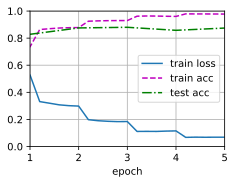

In [8]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

下面我们使用训练有素的模型来预测两个简单句子的情绪。


In [9]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 摘要

* 一维 CNN 可以处理本地特征，例如文本中的 $n$ 克。
* 多输入通道一维交叉关系等同于单输入通道二维交叉关系。
* 最大时间池允许在不同频道执行不同数量的时间步长。
* textCNN 模型使用一维卷积层和最大时间库层将单个令牌表示形式转换为下游应用程序输出。

## 练习

1. 在 :numref:`sec_sentiment_rnn` 和本节中调整超参数并比较两个体系结构以进行情绪分析，例如分类准确性和计算效率。
1. 你能否通过使用 :numref:`sec_sentiment_rnn` 练习中介绍的方法来进一步提高模型的分类准确性？
1. 在输入表示中添加位置编码。它能提高分类准确性吗？


[Discussions](https://discuss.d2l.ai/t/1425)
